In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import emcee
import corner
from scipy.optimize import minimize

from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM

from scipy import integrate
from scipy.interpolate import RegularGridInterpolator

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "GFS Artemisia"
plt.rcParams['mathtext.fontset'] = "cm"

c = c.to(u.km/u.s).value  # km/s
print(c)

299792.458


In [2]:
def sin_d(x):
	""" sine in degrees for convenience """
	return np.sin(x*np.pi/180.)

def cos_d(x):
	""" cosine in degrees, for convenience """
	return np.cos(x*np.pi/180.)

def dmdz(z):
	""" converts uncertainty in redshift to uncertainty in magnitude, for clarity"""
	return 5./(np.log(10)*z)


""" functions to correct for peculiar velocities using 2M++ velocity field (Carrick+ 2015) """
#params of CMB dipole w.r.t. heliocentric frame (Bennett+ 2003)
v_helio = 371.
l_h = 263.85 # galactic longitude
b_h = 48.25 # galactic latitude

#2M++ velocity field from Carrick et al. 2015
velocity_field = np.load('/home/tomas/Downloads/twompp_velocity.npy')

def process_reconstruction_data(box_size, Corner, N_grid):
    '''read and interpolate density and velocity fields'''
    print('Entering reconstruction data interpolation....')
    l = box_size/N_grid

    X = np.linspace(Corner, Corner+box_size, N_grid)
    Y = np.linspace(Corner, Corner+box_size, N_grid)
    Z = np.linspace(Corner, Corner+box_size, N_grid)

    v_data = velocity_field

    v_x_data, v_y_data, v_z_data = v_data

    v_x_interp = RegularGridInterpolator((X, Y, Z), v_x_data)
    v_y_interp = RegularGridInterpolator((X, Y, Z), v_y_data)
    v_z_interp = RegularGridInterpolator((X, Y, Z), v_z_data)

    print('Exiting reconstruction data interpolation....')
    return [v_x_interp, v_y_interp, v_z_interp]

box_size = 400.
Corner = -200.
N_GRID = 257
v_field = process_reconstruction_data(box_size, Corner, N_GRID)

omega_m=0.30 
omega_k=0.   
omega_L=0.70 

def e_z_LCDM(z):
    return (1.0/np.sqrt(omega_m*((1+z)**3)+ omega_k*((1+z)**2) + omega_L))
    e_z_int_LCDM, e_z_int_err_LCDM = integrate.quad(e_z_LCDM,0.,z)

def r_com(z):                   # We define comoving distance for flat universe in Mpc/h
    return (c*integrate.quad(e_z_LCDM,0.,z)[0])

def correct_redshift(z_hel, ez_hel, ra, dec):

    #First step, transform ra dec to Galactic coordinates
    c_icrs = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    l=c_icrs.galactic.l.value
    b=c_icrs.galactic.b.value

    #hel to CMB frame
    cmb_corr = v_helio/c*(sin_d(b)*sin_d(b_h)+cos_d(b)*cos_d(b_h)*cos_d(l-l_h))
    cz_cmb = c*z_hel+cmb_corr*c
    cz_cmb2 = c*(z_hel+ez_hel)+cmb_corr*c
    z_cmb=cz_cmb/c
    ez_cmb=cz_cmb2/c-z_cmb
    """ look up velocity field to find peculiar velocity vector
    input needs to be heliocentric position (and in degrees)
    output is vector in galactic cartesian coordinates, in CMB frame
    """
    #distance in 2M++ grid, vel/100, considering it include h
    #The velocities are predicted peculiar velocities in the CMB frame in Galactic Cartesian coordinate
    D2mpp=r_com(z_cmb)/100 #comoving
    #transform l,b,D2mpp to X,Y,Z 
    c_2mpp = SkyCoord(l=l*u.degree, b=b*u.degree, frame='galactic',distance=D2mpp*u.Mpc)
    X=c_2mpp.cartesian.x.value
    Y=c_2mpp.cartesian.y.value
    Z=c_2mpp.cartesian.z.value

    try:
        Vx,Vy,Vz=v_field[0]([X,Y,Z])[0],v_field[1]([X,Y,Z])[0],v_field[2]([X,Y,Z])[0]

    except ValueError:
        Vx,Vy,Vz=[0,0,0] #outside velocity field; approximate as zero

    vpec = np.array([Vx, Vy, Vz])
    #peculiar redshift
    z_p = vpec.dot(np.array([cos_d(l)*cos_d(b),sin_d(l)*cos_d(b), sin_d(b)]))/c
    corr_term = 1 - cmb_corr + z_p
    z_cmb_corr=(1+z_hel)/corr_term - 1
    #return z_hel,z_cmb,z_cmb_corr,z_p*c,D2mpp
    return z_hel, z_cmb, ez_cmb, z_cmb_corr

Entering reconstruction data interpolation....
Exiting reconstruction data interpolation....


In [63]:
def add_coordinates(sn_df):
    """Adds the SN RA and DEC coordinates (in degrees) 
    from a SNooPy file.
    
    Parameters
    ----------
    sn_df: DataFrame
        DataFrame with at least the SN names.
        
    Returns
    -------
    sn_df: DataFrame
        DataFrame updated with SN coordinates.
    """
    ra_list = []
    dec_list = []

    for sn_name in sn_df.name:
        sn_file = f'csp_data/{sn_name}_snpy.txt'
        with open(sn_file, 'r') as f:
            _, _, ra, dec = f.readline().split()

        ra_list.append(float(ra))
        dec_list.append(float(dec))
        
    sn_df['ra'] = np.array(ra_list)
    sn_df['dec'] = np.array(dec_list)
    
    return sn_df

def add_corrected_z(sn_df):
    """Adds the CMB corrected redshift plus Carrick+2015 
    correction.
    
    Parameters
    ----------
    sn_df: DataFrame
        DataFrame with at least the SN redshifts and coordinates.
        
    Returns
    -------
    sn_df: DataFrame
        DataFrame updated with SN corrected redshifts.
    """
    ra = sn_df.ra.values
    dec = sn_df.dec.values
    z = sn_df.z.values
    z_err = 0.001*z

    corr_z_info = list(map(correct_redshift, z, z_err, ra, dec))
    z_hel, z_cmb , z_cmb_err, z_cmb_corr = np.array(corr_z_info).T
    
    sn_df['z_cmb'] = np.array(z_cmb)
    sn_df['z_cmb_err'] = np.array(z_cmb_err)
    sn_df['z_cmb_corr'] = np.array(z_cmb_corr)
    
    return sn_df

def extract_parameters(sn_name, param, ref_bands, nir_bands, n_epochs):
    """Extracts the parameters of a SN (e.g., Jmax).
    
    Parameters
    ==========
    sn_name: str
        SN name (e.g., SN2004eo).
    params: str
        SN parameter (e.g., Jmax, Tmax, st).
    ref_bands: str
        Bands used for the reference fits. E.g., `AllBands`,
        `Allminusu`, 'grJH', 'gr' and 'gp' (gaussian process).
    nir_bands: str
        NIR bands used for the simulations fits. E.g., `J`, 
        `H` or `JH`.
    n_epochs: int
        Number of epochs for the combinatories of the 
        simulations.
        
    Returns
    =======
    y: array
        Parameter from the simulations fits.
    yerr: array
        Uncertainty of the parameter.
    m1: array
        m1 metric.
    """
    
    ref_bands_options = ['AllBands', 'Allminusu', 
                         'grJH', 'gr', 'gp']
    ref_message = ('only one of the followingis a valid ' 
                  f'option for `red_bands`: {ref_bands_options}')
    assert ref_bands in ref_bands_options, ref_message
    
    nir_bands_options = ['J', 'H', 'JH']
    nir_message = ('only one of the followingis a valid ' 
                  f'option for `nir_bands`: {nir_bands_options}')
    assert nir_bands in nir_bands_options, nir_message

    # sim
    sim_file = os.path.join('sim_fits', 
                            sn_name, 
                            (f'{sn_name}_{n_epochs}'
                             f'epochs_results_{nir_bands}.csv'))
    if os.path.isfile(sim_file):
        sim_df = pd.read_csv(sim_file)
        y = sim_df[param].values
        yerr = sim_df[param+'_err'].values   
        m1 = sim_df['m1'].values
    else:
        y = yerr = m1 = [np.nan]

    return y, yerr, m1

def create_sims_df(param, ref_bands, nir_bands, n_epochs, ref_df):
    """Extracts the parameters of a SN (e.g., Jmax and 
    metrics) and returns a DataFrame.
    
    Parameters
    ==========
    sn_name: str
        SN name (e.g., SN2004eo).
    params: str
        SN parameter (e.g., Jmax, Tmax, st).
    ref_bands: str
        Bands used for the reference fits. E.g., `AllBands`,
        `Allminusu`, 'grJH', 'gr' and 'gp' (gaussian process).
    nir_bands: str
        NIR bands used for the simulations fits. E.g., `J`, 
        `H` or `JH`.
    n_epochs: int
        Number of epochs for the combinatories of the 
        simulations.
        
    Returns
    -------
    sims_df: DataFrame
        Pandas dataframe with the parameters of the simulations.
    """
    params_list = []
    for sn_name, z in zip(ref_df.name, ref_df.z):

        y, yerr, m1 = extract_parameters(sn_name, param, 
                                        ref_bands, nir_bands, 
                                         n_epochs)

        params_dict = {'name':[sn_name]*len(y), 
                       'z':[z]*len(y),
                       param:y, param+'_err':yerr,
                       'phase':m1}
        param_df = pd.DataFrame(params_dict)
        params_list.append(param_df)

    sims_df = pd.concat(params_list, ignore_index=True)
    sims_df = sims_df.sort_values('z')
    sims_df = add_coordinates(sims_df)
    sims_df = add_corrected_z(sims_df)
    
    # correction snake
    outfile = f'correction_snake_{param[0]}_{n_epochs}epoch.npy'
    X, Y, YERR = np.load(outfile)
    
    mmax_corr = []
    mmax_corr_err = []
    for phase in sims_df.phase:
        ind = np.argmin(np.abs(phase-X))
        mmax_corr.append(Y[ind])
        mmax_corr_err.append(YERR[ind])
        
    sims_df['mmax_corr'] = mmax_corr
    sims_df['mmax_corr_err'] = mmax_corr_err
    
    return sims_df

In [80]:
ref_bands = 'AllBands'
nir_bands = 'JH'
param = 'Jmax'
n_epochs = 1
band = param[0]


# reference sample
ref_df = pd.read_csv('reference_results_max_model.csv')
ref_df = ref_df.sort_values('z')
ref_df = add_coordinates(ref_df)
ref_df = add_corrected_z(ref_df)

# calibrator sample
calib_dict = {'SN2007af':[-18.340, 0.046],
             'SN2015F':[-18.430, 0.058],}

sn_list = []
for sn in calib_dict.keys():
    M, M_err = calib_dict[sn]
    sn_df = ref_df[ref_df.name==sn]
    sn_df['M'] = np.array(M)
    sn_df['M_err'] = np.array(M_err)
    sn_list.append(sn_df)
    ref_df = ref_df[ref_df.name!=sn]
    
calib_df = pd.concat(sn_list)

# simulations
sims_df = create_sims_df(param, ref_bands, 
                          nir_bands, n_epochs, ref_df)
mask = (sims_df.phase>-5) & (sims_df.phase<15)
sims_df = sims_df[mask]

#-----------
# parameters

# ref
z_ref = ref_df.z_cmb_corr.values
#z_ref = ref_df.z.values
mag_ref = ref_df[f'{param}_{ref_bands}'].values

mag_err_ref = ref_df[f'{param}_err_{ref_bands}'].values
pec_err_ref = (5/np.log(10))*(150/(c*z_ref))
z_err_ref = (5/np.log(10))*(ref_df.z_cmb_err.values/z_ref)
err_ref = np.sqrt(mag_err_ref**2 + pec_err_ref**2 + z_err_ref**2)

# calib
z_calib = calib_df.z_cmb_corr.values
#z_calib = calib_df.z.values
mag_calib = calib_df[f'{param}_{ref_bands}'].values
M_calib = calib_df['M'].values

mag_err_calib = calib_df[f'{param}_err_{ref_bands}'].values
M_err_calib = calib_df['M_err'].values
err_calib = np.sqrt(mag_err_calib**2 + M_err_calib**2)

# sims
z_sims = sims_df.z_cmb_corr.values
#z_sims = sims_df.z.values
mag_sims = sims_df[param].values - sims_df['mmax_corr'].values

mag_err_sims = sims_df[f'{param}_err'].values
mmax_corr_err = sims_df['mmax_corr_err'].values
pec_err_sims = (5/np.log(10))*(150/(c*z_sims))
z_err_sims = (5/np.log(10))*(sims_df.z_cmb_err.values/z_sims)
err_sims = np.sqrt(mag_err_sims**2 + pec_err_sims**2 + z_err_sims**2 + mmax_corr_err**2)

/tmp/ipykernel_20814/2446157794.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sn_df['M'] = np.array(M)
/tmp/ipykernel_20814/2446157794.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sn_df['M_err'] = np.array(M_err)
/tmp/ipykernel_20814/2446157794.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

### $
m_{sim} =  m_{fit} - m_{corr}
$

### $
\sigma_{z} \approx \frac{5}{\ln 10} \frac{\sigma_{z}}{z} \quad \text { and } \quad \sigma_{\text {pec}} \approx \frac{5}{\ln 10} \frac{\sigma_{\mathrm{pec}}}{c z}
$

### $
\sigma_{calib, i}^{2}=\sigma_{\mathrm{fit}, i}^{2}+\sigma_{\mathrm{\mu}, i}^{2}+\sigma_{\mathrm{int}}^{2}
$

### $
\sigma_{m, k}^{2}=\sigma_{\mathrm{fit}, k}^{2}+\sigma_{z, k}^{2}+\sigma_{\text {pec}, k}^{2}+\sigma_{\mathrm{int}}^{2}
$

### $
\sigma_{\mathrm{sim}, m, k}^{2}=\sigma_{\mathrm{fit}, k}^{2}+\sigma_{z, k}^{2}+\sigma_{\text {pec}, k}^{2}+\sigma_{\mathrm{corr}}^{2}+\sigma_{\mathrm{int}}^{2}
$
___

In [81]:
def log_likelihood(theta, z, mag, mag_err, z_calib, M_calib, mag_calib, mag_err_calib):    
    M, H0, err_int = theta
    
    # ref
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3, Tcmb0=2.725)
    mu_cosmo = cosmo.distmod(z).value
    
    mu = mag - M
    sigma2 = err_int**2 + mag_err**2
    ref_residual = -0.5 * np.sum((mu - mu_cosmo)**2 / sigma2 + np.log(2*np.pi*sigma2))
    
    # calib
    cosmo = FlatLambdaCDM(H0=H0, Om0=0.3, Tcmb0=2.725)
    mu_cosmo = cosmo.distmod(z_calib).value
    
    mu = mag_calib - M_calib
    sigma2 = err_int**2 + mag_err_calib**2
    calib_residual = -0.5 * np.sum((mu - mu_cosmo)**2 / sigma2 + np.log(2*np.pi*sigma2))
    
    return ref_residual + calib_residual

def log_prior(theta):
    M, H0, err_int = theta
    if 0.0<H0 and 0.0<err_int:
        return -np.log(err_int)
    return -np.inf

def log_probability(theta, z, mag, mag_err, z_calib, M_calib, mag_calib, mag_err_calib):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, z, mag, mag_err, z_calib, M_calib, mag_calib, mag_err_calib)

In [82]:
np.random.seed(42)
args = (z_ref, mag_ref, err_ref, z_calib, M_calib, mag_calib, err_calib)

nll = lambda *args: -log_likelihood(*args)
p0 = np.array([-18.5, 75, 0.1])
initial = p0 + 0.1*np.random.randn(3)
soln = minimize(nll, initial, args=args)
print(soln.x)

[-18.34295041  81.5064465    0.29222714]


In [30]:
pos = soln.x + 1e-4 * np.random.randn(50, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, 
                                log_probability, args=args, threads=10)
sampler.run_mcmc(pos, 1000, progress=True);

100%|████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:53<00:00,  5.77it/s]


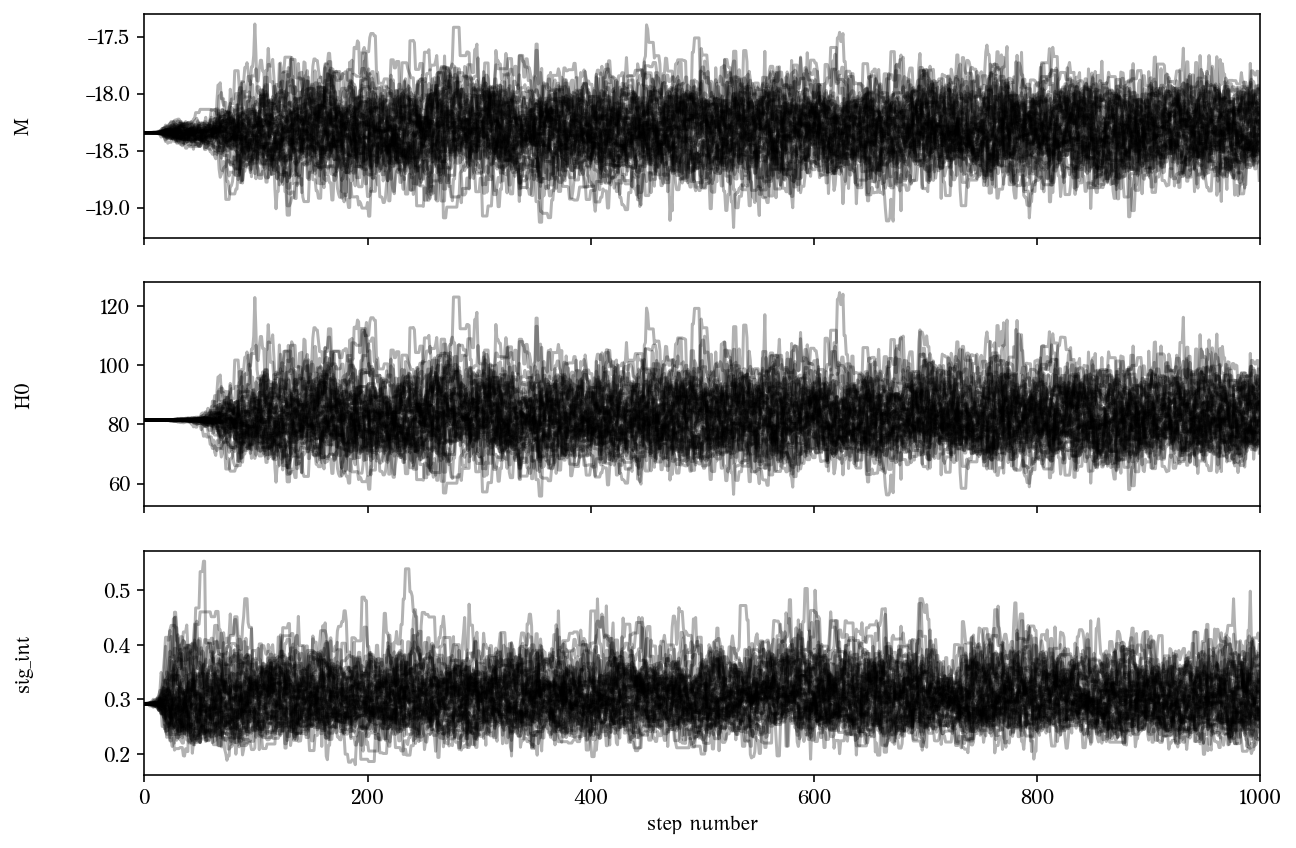

In [31]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["M", "H0", "sig_int"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

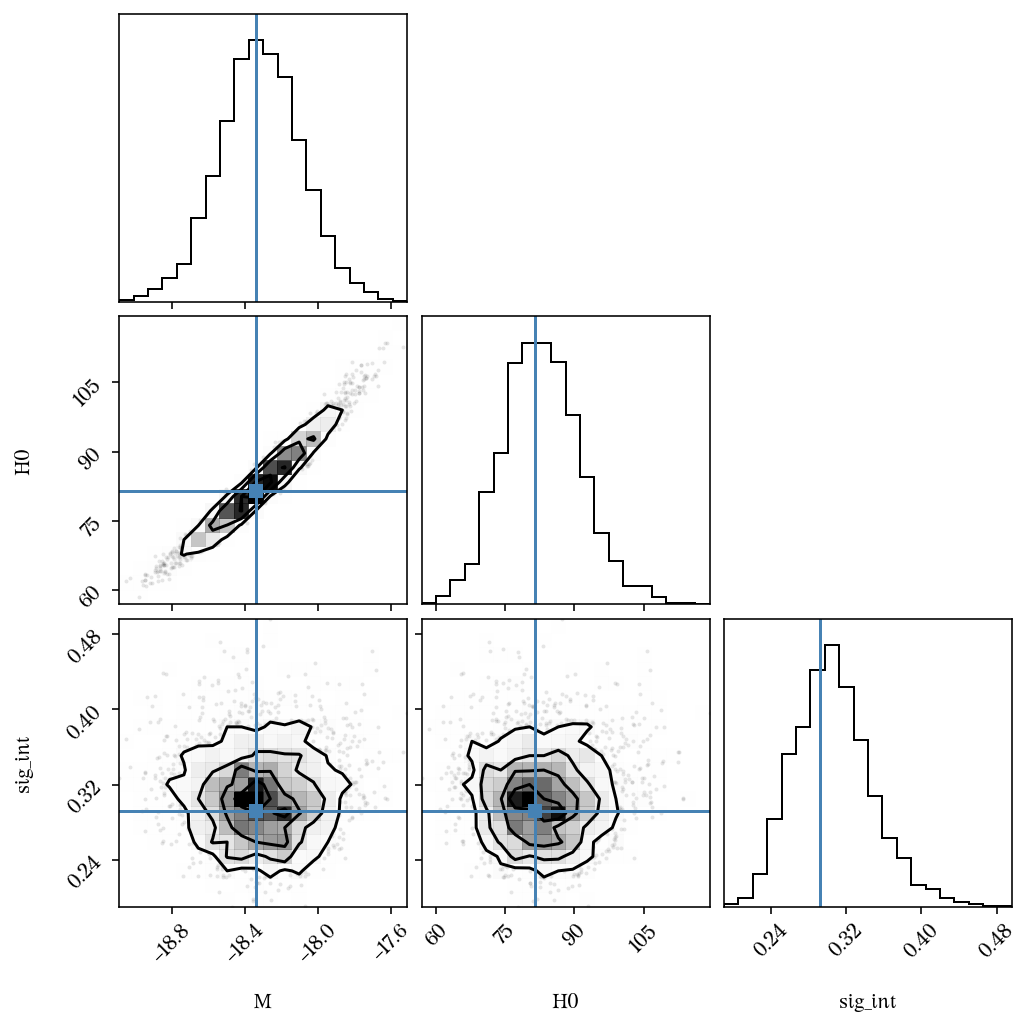

In [85]:
flat_samples = sampler.get_chain(discard=150, thin=15, flat=True)

fig = corner.corner(flat_samples, labels=labels, 
                    truths=soln.x
                   );

In [33]:
params_dict = {'M':None,
              'H0':None,
              'sig_int':None}

for i, param in zip(range(ndim), params_dict.keys()):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f'{mcmc[1]}, {q[0]}, {q[1]}')
    params_dict[param] = mcmc[1]

-18.314664537079018, 0.22007939980322533, 0.22176108047574772
82.63460618201785, 7.85719513351566, 8.523210188057206
0.3042053540171319, 0.039445246077391194, 0.04154719511148319


/home/tomas/anaconda3/envs/flows_sims/lib/python3.10/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


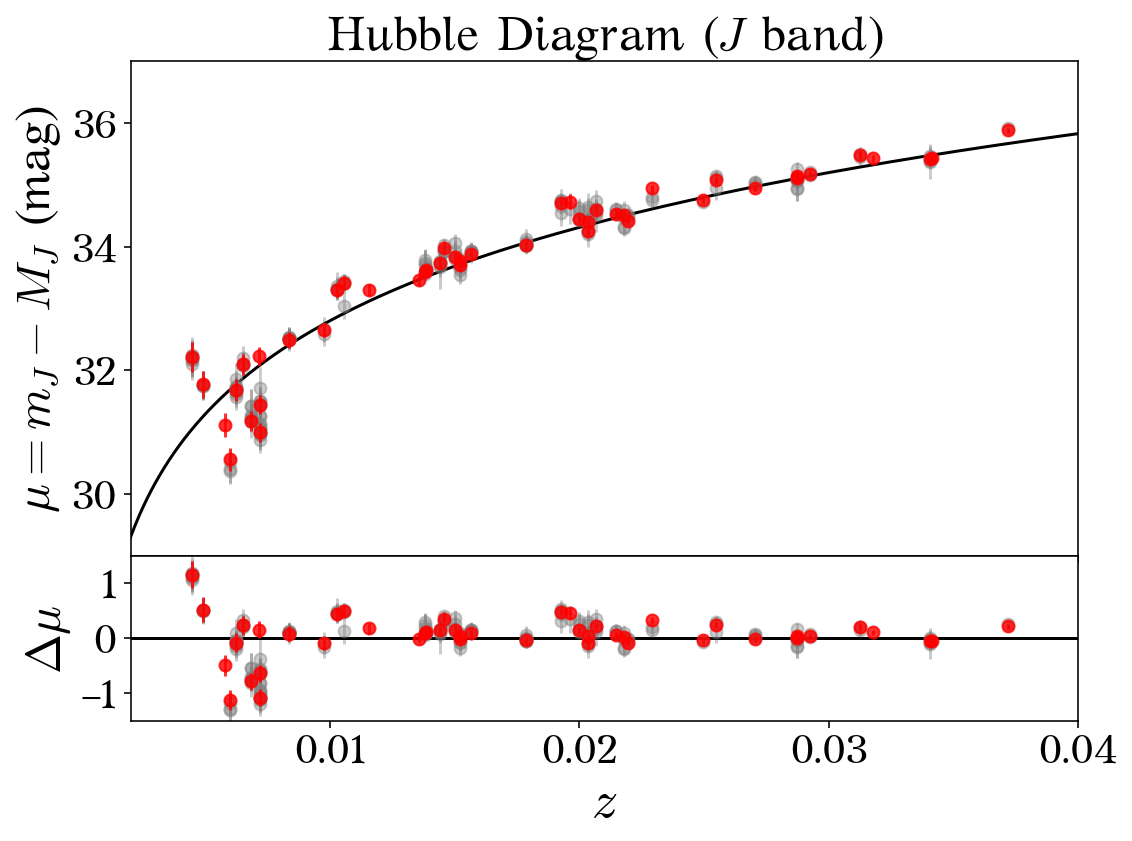

In [83]:
M = params_dict['M']
H0 = params_dict['H0']
sig_int = params_dict['sig_int']
cosmo = FlatLambdaCDM(H0=H0, Om0=0.99, Tcmb0=2.725)

M, H0, sig_int = soln.x

z_cosmo = np.linspace(0, 0.05, 1000)
mu_cosmo = cosmo.distmod(z_cosmo).value
tot_err_ref = np.sqrt(err_ref**2 + sig_int**2)
tot_err_sims = np.sqrt(err_sims**2 + sig_int**2)

#------------------
# plots
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                       gridspec_kw={'hspace':0, 
                                    'height_ratios':[3,1]})
    
# HD
ax[0].errorbar(z_ref, mag_ref-M, yerr=err_ref, 
            fmt='o', color='red', alpha=0.8, zorder=10)
ax[0].errorbar(z_sims, mag_sims-M, yerr=err_sims, 
            fmt='o', color='gray', alpha=0.4)
ax[0].plot(z_cosmo, mu_cosmo, c='k')

# residual
res_ref = (mag_ref-M)-cosmo.distmod(z_ref).value
res_sims = (mag_sims-M)-cosmo.distmod(z_sims).value
ax[1].errorbar(z_ref, res_ref, yerr=err_ref, 
               fmt='o', color='red', alpha=0.8, zorder=10)
ax[1].errorbar(z_sims, res_sims, yerr=err_sims, 
               fmt='o', color='gray', alpha=0.4)
ax[1].axhline(0, c='k')
   
ax[0].set_ylabel(r'$\mu = m_{%s} - M_{%s}$ (mag)'%(band, band), fontsize=24)
ax[0].set_title(f'Hubble Diagram (${band}$ band)', fontsize=24)
ax[0].tick_params(labelsize=20)
ax[0].set_ylim(29, 37)

ax[1].set_xlabel('$z$', fontsize=26)
ax[1].set_ylabel(r'$\Delta \mu$', fontsize=24)
ax[1].tick_params(labelsize=20)
ax[1].set_ylim(-1.5, 1.5)
ax[1].set_xlim(0.002, 0.04)

fig.tight_layout()
#plt.savefig(f'paper_plots/{param}_residuals.jpg')
plt.show()

In [84]:
rms_ref = np.sqrt(np.mean(res_ref**2))
rms_sims = np.sqrt(np.nanmean(res_sims**2))
print(rms_ref, rms_sims)

0.3799659549325126 0.4685116168005284
